In [31]:
!pip install skyfield
import numpy as np


In [33]:
import os

print("Current Directory:", os.getcwd())

file_path = 'ISS_TLE.txt'  # Change this if the file is in a sub-folder
print("File Exists:", os.path.exists(file_path))


Current Directory: /Users/utsavmittal/new task
File Exists: True


In [35]:
tle_file = file_path
name, line1, line2 = read_tle(tle_file)
print("🛰️ Satellite Name:", name)
print("📄 TLE Line 1:", line1)
print("📄 TLE Line 2:", line2)

🛰️ Satellite Name: ISS (ZARYA)
📄 TLE Line 1: 1 25544U 98067A   21267.59097222  .00001387  00000-0  32258-4 0  9993
📄 TLE Line 2: 2 25544  51.6451 156.6514 0001537 119.2475 302.8555 15.48985525205859


In [37]:
from skyfield.api import load, EarthSatellite

name = name
line1 = line1
line2 = line2

satellite = EarthSatellite(line1, line2, name)
ts = load.timescale()


In [39]:
# Get the current time
current_time = ts.now()

# Calculate the satellite's position
geocentric = satellite.at(current_time)
subpoint = geocentric.subpoint()

# Display the position
print(f"🛰️ Satellite: {name}")
print(f"📍 Latitude: {subpoint.latitude.degrees:.2f}°")
print(f"📍 Longitude: {subpoint.longitude.degrees:.2f}°")
print(f"📏 Altitude: {subpoint.elevation.km:.2f} km")


🛰️ Satellite: ISS (ZARYA)
📍 Latitude: -25.48°
📍 Longitude: -7.83°
📏 Altitude: 414.34 km


In [41]:
# Predict satellite position 1 hour later
future_time = ts.now() + (1 / 24)  # 1 hour later

future_geocentric = satellite.at(future_time)
future_subpoint = future_geocentric.subpoint()

print(f"🕒 Time: {future_time.utc_datetime()}")
print(f"📍 Future Latitude: {future_subpoint.latitude.degrees:.2f}°")
print(f"📍 Future Longitude: {future_subpoint.longitude.degrees:.2f}°")
print(f"📏 Future Altitude: {future_subpoint.elevation.km:.2f} km")


🕒 Time: 2024-12-24 19:22:38.646982+00:00
📍 Future Latitude: -15.87°
📍 Future Longitude: -168.13°
📏 Future Altitude: 409.65 km


In [57]:
pip install filterpy


  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=9771080458c5be7e89adb87b88887594136e0571759c69ca35939003be0a3e05
  Stored in directory: /Users/utsavmittal/Library/Caches/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from skyfield.api import load, EarthSatellite

# Load TLE Data from your file
with open('ISS_TLE.txt', 'r') as f:
    tle_lines = f.readlines()

name = tle_lines[0].strip()
line1 = tle_lines[1].strip()
line2 = tle_lines[2].strip()

# Create a satellite object
satellite = EarthSatellite(line1, line2, name)

# Load the time scale
ts = load.timescale()

# Set the start time and generate time intervals (every 10 minutes for 24 hours)
start_time = ts.now()
time_intervals = [start_time + (i / 144) for i in range(144)]  # 144 intervals (10 minutes each)

# Prepare to store results
orbit_data = []

# Compute ISS positions
for time in time_intervals:
    geocentric = satellite.at(time)
    subpoint = geocentric.subpoint()
    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees
    altitude = subpoint.elevation.km
    utc_time = time.utc_strftime("%Y-%m-%d %H:%M:%S")
    orbit_data.append(f"{utc_time}, {latitude:.2f}, {longitude:.2f}, {altitude:.2f}\n")

# Save data to a file
output_file = 'InputData_ISS.txt'
with open(output_file, 'w') as f:
    f.writelines(orbit_data)

print(f"✅ Orbit data saved to {output_file}")


✅ Orbit data saved to InputData_ISS.txt


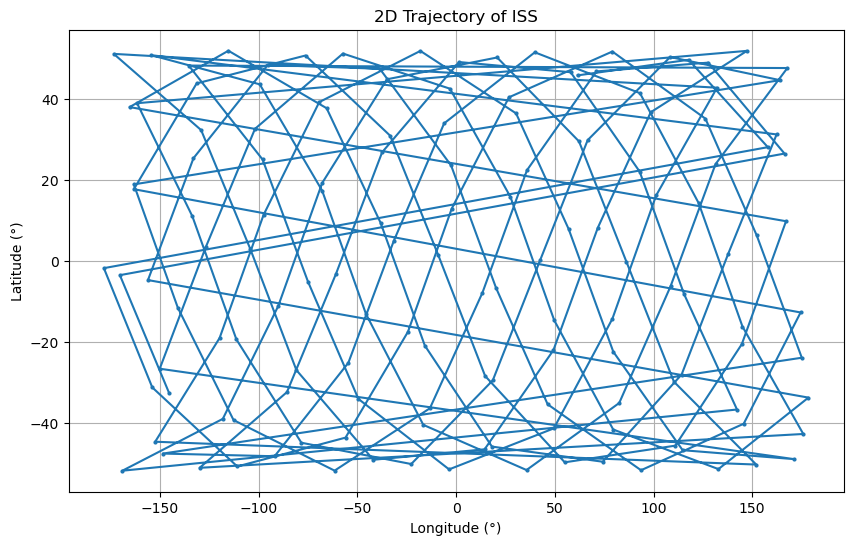

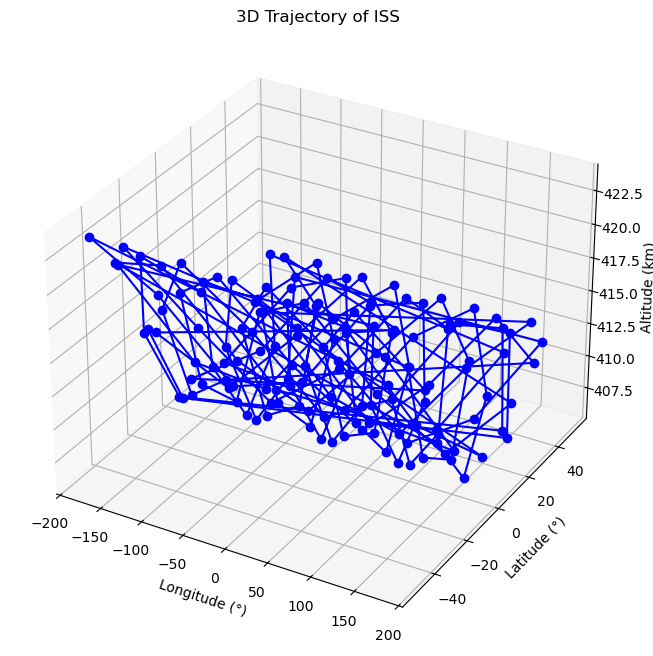

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the orbit data from the file
input_file = 'InputData_ISS.txt'

# Initialize lists to store data
times = []
latitudes = []
longitudes = []
altitudes = []

# Read the file and extract data
with open(input_file, 'r') as f:
    for line in f:
        parts = line.strip().split(', ')
        times.append(parts[0])  # UTC Time
        latitudes.append(float(parts[1]))  # Latitude
        longitudes.append(float(parts[2]))  # Longitude
        altitudes.append(float(parts[3]))  # Altitude

# Plot 2D trajectory
plt.figure(figsize=(10, 6))
plt.plot(longitudes, latitudes, marker='o', markersize=2, linestyle='-')
plt.title('2D Trajectory of ISS')
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.grid()
plt.show()

# Plot 3D trajectory
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(longitudes, latitudes, altitudes, marker='o', linestyle='-', color='b')
ax.set_title('3D Trajectory of ISS')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_zlabel('Altitude (km)')
plt.show()

### 1. Verifying Orbit Data
We calculated the orbit of the ISS using TLE data and generated positions over 24 hours. The data was visualized in:
- **2D Plot**: Longitude vs. Latitude.
- **3D Plot**: Longitude, Latitude, and Altitude.

### 2. Observations
- The 2D plot shows a sinusoidal path, as expected.
- The 3D plot highlights the ISS's trajectory with consistent altitude variations.

### 3. Data Quality
The data in `InputData_ISS.txt` appears consistent, with no abrupt changes in values.


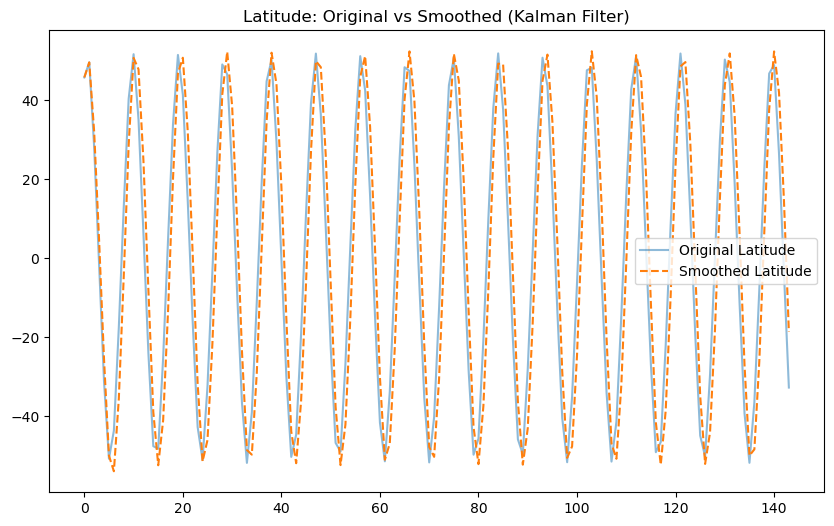

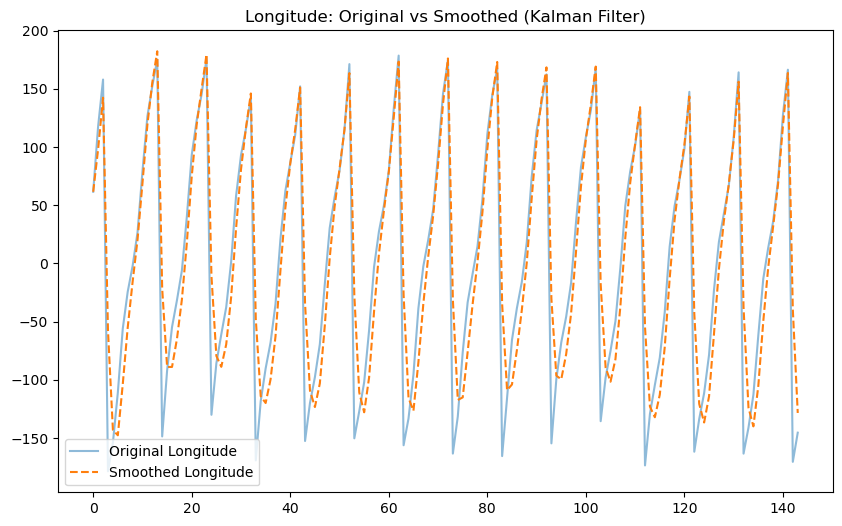

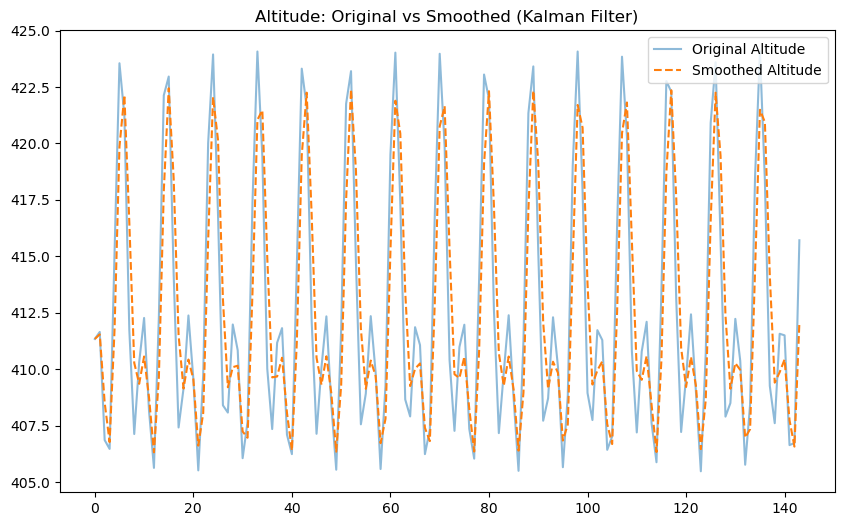

In [9]:
from filterpy.kalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# Load the ISS orbit data
input_file = 'InputData_ISS.txt'

# Initialize lists to store data
times = []
latitudes = []
longitudes = []
altitudes = []

# Read data from file
with open(input_file, 'r') as f:
    for line in f:
        parts = line.strip().split(', ')
        times.append(parts[0])  # UTC Time
        latitudes.append(float(parts[1]))  # Latitude
        longitudes.append(float(parts[2]))  # Longitude
        altitudes.append(float(parts[3]))  # Altitude

# Convert data to numpy arrays for processing
latitudes = np.array(latitudes)
longitudes = np.array(longitudes)
altitudes = np.array(altitudes)

# Kalman Filter for Constant Velocity Model (latitude example)
kf_lat = KalmanFilter(dim_x=2, dim_z=1)
kf_lat.x = np.array([latitudes[0], 0])  # Initial state (position and velocity)
kf_lat.F = np.array([[1, 1], [0, 1]])  # State transition matrix
kf_lat.H = np.array([[1, 0]])          # Measurement function
kf_lat.P *= 1000                       # Covariance matrix
kf_lat.R = 5                           # Measurement noise
kf_lat.Q = np.eye(2)                   # Process noise

# Apply Kalman Filter to smooth latitude data
smoothed_latitudes = []
for lat in latitudes:
    kf_lat.predict()
    kf_lat.update(lat)
    smoothed_latitudes.append(kf_lat.x[0])

# Repeat for longitude and altitude
kf_lon = KalmanFilter(dim_x=2, dim_z=1)
kf_lon.x = np.array([longitudes[0], 0])
kf_lon.F = kf_lat.F
kf_lon.H = kf_lat.H
kf_lon.P = kf_lat.P
kf_lon.R = kf_lat.R
kf_lon.Q = kf_lat.Q

smoothed_longitudes = []
for lon in longitudes:
    kf_lon.predict()
    kf_lon.update(lon)
    smoothed_longitudes.append(kf_lon.x[0])

kf_alt = KalmanFilter(dim_x=2, dim_z=1)
kf_alt.x = np.array([altitudes[0], 0])
kf_alt.F = kf_lat.F
kf_alt.H = kf_lat.H
kf_alt.P = kf_lat.P
kf_alt.R = kf_lat.R
kf_alt.Q = kf_lat.Q

smoothed_altitudes = []
for alt in altitudes:
    kf_alt.predict()
    kf_alt.update(alt)
    smoothed_altitudes.append(kf_alt.x[0])

# Plot Smoothed vs Original Data
plt.figure(figsize=(10, 6))
plt.plot(latitudes, label='Original Latitude', alpha=0.5)
plt.plot(smoothed_latitudes, label='Smoothed Latitude', linestyle='--')
plt.title('Latitude: Original vs Smoothed (Kalman Filter)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(longitudes, label='Original Longitude', alpha=0.5)
plt.plot(smoothed_longitudes, label='Smoothed Longitude', linestyle='--')
plt.title('Longitude: Original vs Smoothed (Kalman Filter)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(altitudes, label='Original Altitude', alpha=0.5)
plt.plot(smoothed_altitudes, label='Smoothed Altitude', linestyle='--')
plt.title('Altitude: Original vs Smoothed (Kalman Filter)')
plt.legend()
plt.show()


In [15]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 MB 4.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 5.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.2 MB/s eta 0:00:00a 0:00:01


In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data from 'InputData_ISS.txt'
latitudes, longitudes, altitudes = [], [], []

with open('InputData_ISS.txt', 'r') as file:
    for line in file:
        _, lat, lon, alt = line.strip().split(', ')
        latitudes.append(float(lat))
        longitudes.append(float(lon))
        altitudes.append(float(alt))

# Normalize data to range [0, 1] using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(np.array([latitudes, longitudes, altitudes]).T)

# Create sequences for LSTM (e.g., 10 data points -> 1 prediction)
sequence_length = 10
X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])  # Predict the next point

X, y = np.array(X), np.array(y)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (134, 10, 3)
Shape of y: (134, 3)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(3)  # 3 outputs: latitude, longitude, altitude
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,953 (42.79 KB)

 Trainable params: 10,953 (42.79 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
history = model.fit(
    X, y, 
    epochs=50,          # Number of training iterations
    batch_size=32,      # Number of samples processed at a time
    validation_split=0.2  # Reserve 20% of data for validation
)

# Save the model for future use
model.save('lstm_iss_model.h5')

print("✅ Model training complete and saved as 'lstm_iss_model.h5'")


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.3608 - val_loss: 0.3095
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3127 - val_loss: 0.2650
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2589 - val_loss: 0.2222
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2093 - val_loss: 0.1807
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1656 - val_loss: 0.1427
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1319 - val_loss: 0.1154
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1051 - val_loss: 0.1096
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1039 - val_loss: 0.1110
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1036 - val_loss: 0.1045
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1005 - val_loss: 0.1026
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0987 - val_loss: 0.1037
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0977 - val_loss: 0.1038
E

✅ Model training complete and saved as 'lstm_iss_model.h5'


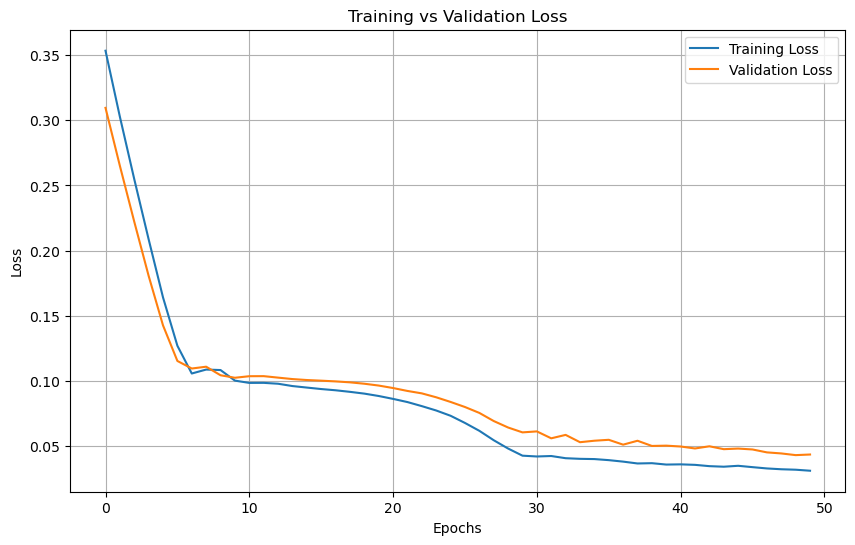

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [35]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# Save the model
model.save('lstm_iss_model.h5')


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0313 - val_loss: 0.0459
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0309 - val_loss: 0.0427
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0280 - val_loss: 0.0424
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0307 - val_loss: 0.0391
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0291 - val_loss: 0.0383
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0265 - val_loss: 0.0380
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0252 - val_loss: 0.0367
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0259 - val_loss: 0.0344
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0264 - val_loss: 0.0341
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0251 - val_loss: 0.0325
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - val_loss: 0.0313
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0218 - val_loss: 0.0297
E

In [37]:
from tensorflow.keras.models import load_model

model = load_model('lstm_iss_model.h5')


In [39]:
# Load the trained model (if not already loaded)
from tensorflow.keras.models import load_model

model = load_model('lstm_iss_model.h5')

# Use the trained model to predict positions
predicted_positions = model.predict(X)

# Inverse transform the predictions to get original scale (latitude, longitude, altitude)
predicted_positions = scaler.inverse_transform(predicted_positions)

# Inverse transform the actual values for comparison
actual_positions = scaler.inverse_transform(y)

print("✅ Predictions generated successfully!")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
✅ Predictions generated successfully!


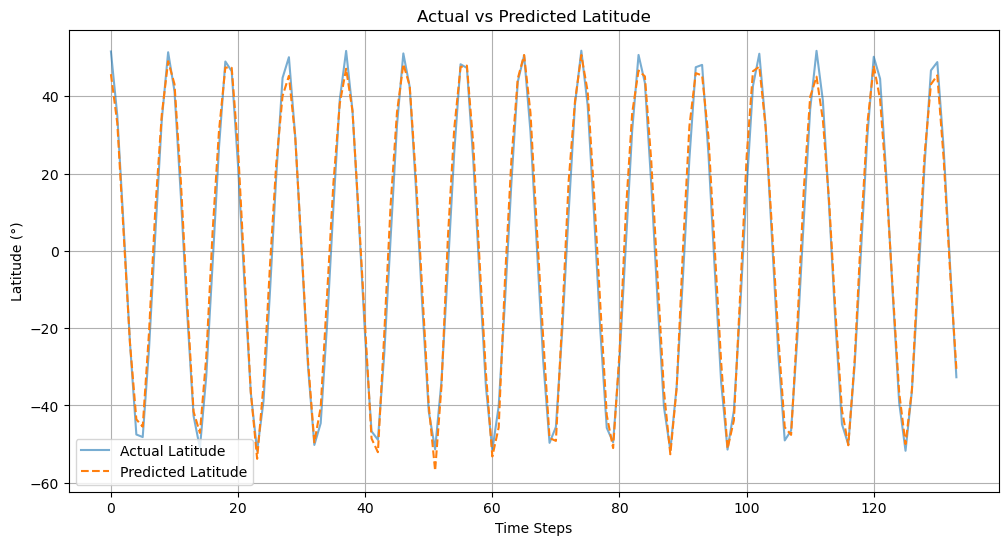

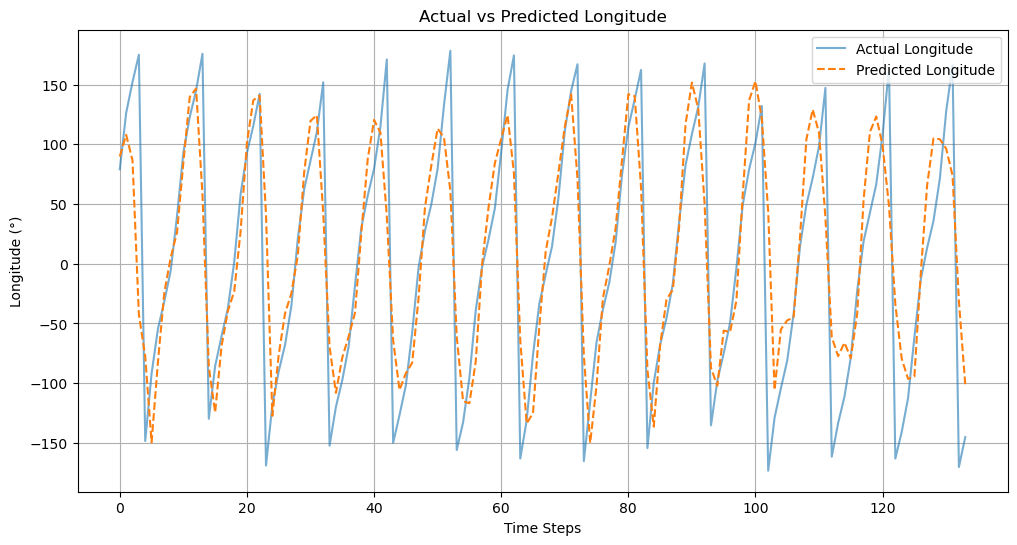

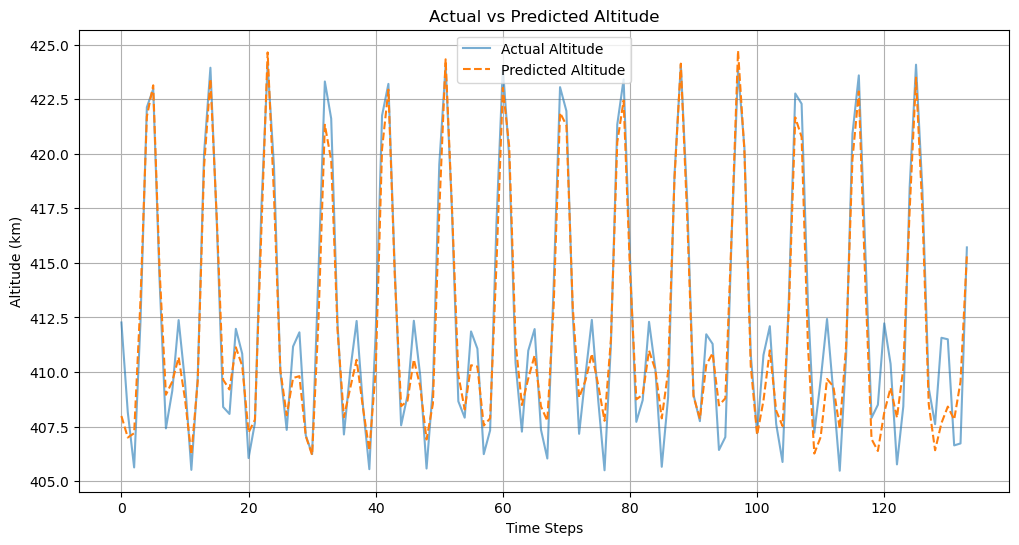

In [41]:
import matplotlib.pyplot as plt

# Plot latitude
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_positions)), actual_positions[:, 0], label='Actual Latitude', alpha=0.6)
plt.plot(range(len(predicted_positions)), predicted_positions[:, 0], label='Predicted Latitude', linestyle='--')
plt.title('Actual vs Predicted Latitude')
plt.xlabel('Time Steps')
plt.ylabel('Latitude (°)')
plt.legend()
plt.grid()
plt.show()

# Plot longitude
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_positions)), actual_positions[:, 1], label='Actual Longitude', alpha=0.6)
plt.plot(range(len(predicted_positions)), predicted_positions[:, 1], label='Predicted Longitude', linestyle='--')
plt.title('Actual vs Predicted Longitude')
plt.xlabel('Time Steps')
plt.ylabel('Longitude (°)')
plt.legend()
plt.grid()
plt.show()

# Plot altitude
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_positions)), actual_positions[:, 2], label='Actual Altitude', alpha=0.6)
plt.plot(range(len(predicted_positions)), predicted_positions[:, 2], label='Predicted Altitude', linestyle='--')
plt.title('Actual vs Predicted Altitude')
plt.xlabel('Time Steps')
plt.ylabel('Altitude (km)')
plt.legend()
plt.grid()
plt.show()


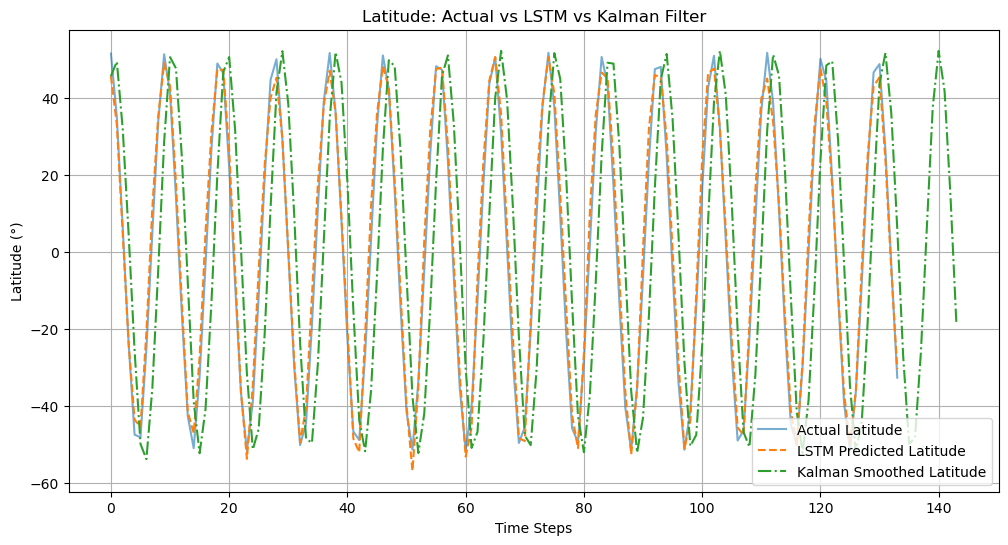

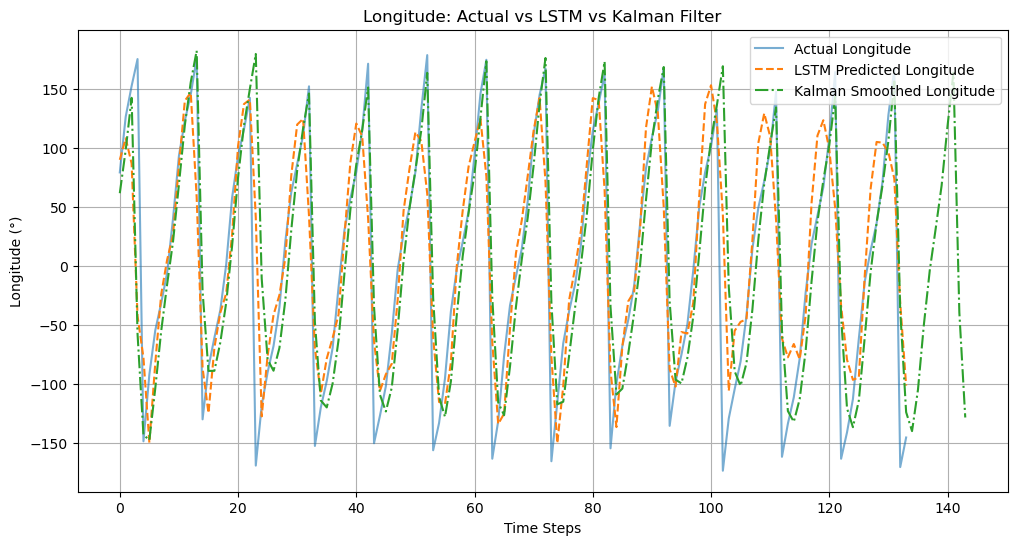

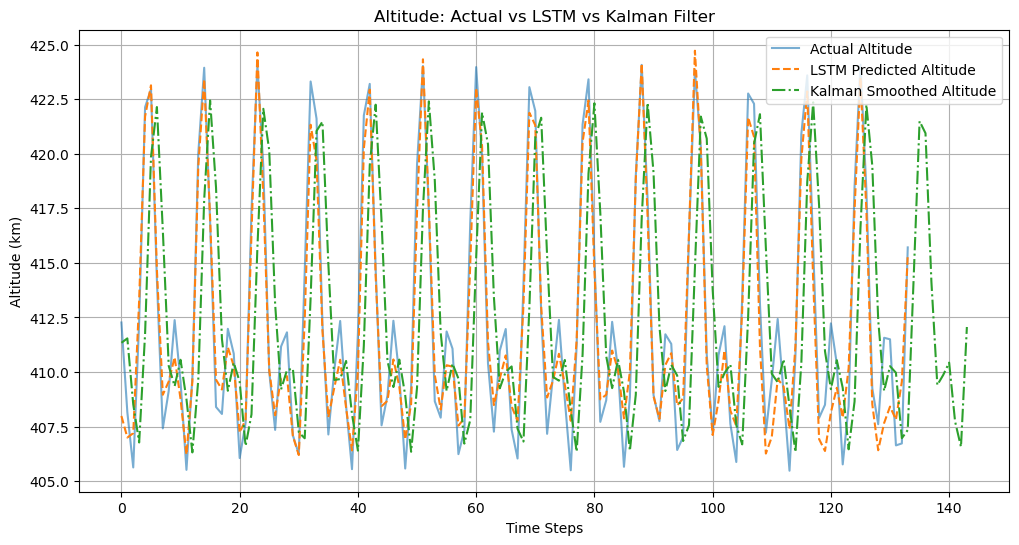

In [45]:
# Plot Latitude Comparison
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_positions)), actual_positions[:, 0], label='Actual Latitude', alpha=0.6)
plt.plot(range(len(predicted_positions)), predicted_positions[:, 0], label='LSTM Predicted Latitude', linestyle='--')
plt.plot(range(len(smoothed_latitudes)), smoothed_latitudes, label='Kalman Smoothed Latitude', linestyle='-.')
plt.title('Latitude: Actual vs LSTM vs Kalman Filter')
plt.xlabel('Time Steps')
plt.ylabel('Latitude (°)')
plt.legend()
plt.grid()
plt.show()

# Plot Longitude Comparison
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_positions)), actual_positions[:, 1], label='Actual Longitude', alpha=0.6)
plt.plot(range(len(predicted_positions)), predicted_positions[:, 1], label='LSTM Predicted Longitude', linestyle='--')
plt.plot(range(len(smoothed_longitudes)), smoothed_longitudes, label='Kalman Smoothed Longitude', linestyle='-.')
plt.title('Longitude: Actual vs LSTM vs Kalman Filter')
plt.xlabel('Time Steps')
plt.ylabel('Longitude (°)')
plt.legend()
plt.grid()
plt.show()

# Plot Altitude Comparison
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_positions)), actual_positions[:, 2], label='Actual Altitude', alpha=0.6)
plt.plot(range(len(predicted_positions)), predicted_positions[:, 2], label='LSTM Predicted Altitude', linestyle='--')
plt.plot(range(len(smoothed_altitudes)), smoothed_altitudes, label='Kalman Smoothed Altitude', linestyle='-.')
plt.title('Altitude: Actual vs LSTM vs Kalman Filter')
plt.xlabel('Time Steps')
plt.ylabel('Altitude (km)')
plt.legend()
plt.grid()
plt.show()


# ISS Trajectory Prediction

## Introduction
This project is a task assigned to me by Mr. Rishi Raj Singh

## Methodology
### Step 1: Parsing TLE Data

### Step 2: Generating Orbit Data

### Step 3: Visualizing the Orbit

### Step 4: Applying Kalman Filter

### Step 5: Building and Training the LSTM Model

### Step 6: Comparing Results

## Results
 As we can see the that Kalmans smooting altitude can be used for forecasting,Predictions are effective

## Challenges and Learnings
 
 Being a mechanical engineering student who is learning web development and DSA, I have no knowledge about AI/ML. In this task, I learned from scratch about Python and Jupyter notebook, taking help from AI assistants to guide me through the given tasks. 
 It was a very dense learning time for me, and I really enjoyed the process.
 Thank you for sharing the task !!!


